# Reducing data-cubes using geometry objects

In [1]:
# If first time running, uncomment the line below to install any additional dependencies
# !bash requirements-for-notebooks.sh

In [2]:
import matplotlib.pyplot as plt

from earthkit.transforms import aggregate as ek_aggregate
from earthkit import data as ek_data

from earthkit.data.testing import earthkit_remote_test_data_file

## Load some test data

All `earthkit-transforms` methods can be called with `earthkit-data` objects (Readers and Wrappers) or with the 
pre-loaded `xarray` or `geopandas` objects.

In this example we will use hourly ERA5 2m temperature data on a 0.5x0.5 spatial grid for the year 2015 as
our physical data; and we will use the NUTS geometries which are stored in a geojson file.

First we lazily load the ERA5 data  and NUTS geometries from our test-data repository.

Note the data is only downloaded when
we use it, e.g. at the `.to_xarray` line, additionally, the download is cached so the next time you run this
cell you will not need to re-download the file (unless it has been a very long time since you have run the
code, please see tutorials in `earthkit-data` for more details in cache management).

In [3]:
# Get some demonstration ERA5 data, this could be any url or path to an ERA5 grib or netCDF file.
# remote_era5_file = earthkit_remote_test_data_file("test-data", "era5_temperature_europe_2015.grib") # Large file
remote_era5_file = earthkit_remote_test_data_file("test-data", "era5_temperature_europe_20150101.grib")
era5_data = ek_data.from_source("url", remote_era5_file)
era5_data.to_xarray()

<xarray.Dataset> Size: 5MB
Dimensions:     (number: 1, time: 24, step: 1, surface: 1, latitude: 201,
                 longitude: 281)
Coordinates:
  * number      (number) int64 8B 0
  * time        (time) datetime64[ns] 192B 2015-01-01 ... 2015-01-01T23:00:00
  * step        (step) timedelta64[ns] 8B 00:00:00
  * surface     (surface) float64 8B 0.0
  * latitude    (latitude) float64 2kB 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 2kB -10.0 -9.75 -9.5 ... 59.5 59.75 60.0
    valid_time  (time, step) datetime64[ns] 192B ...
Data variables:
    t2m         (number, time, step, surface, latitude, longitude) float32 5MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-15T14:00 GRIB to CDM+CF via cfgrib-0.9.1...

In [4]:
# Use some demonstration polygons stored, this could be any url or path to geojson file
remote_nuts_url = earthkit_remote_test_data_file("test-data", "NUTS_RG_60M_2021_4326_LEVL_0.geojson")
nuts_data = ek_data.from_source("url", remote_nuts_url)

nuts_data.to_pandas()[:5]

,id,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
0,DK,DK,0,DK,Danmark,Danmark,0,0,0,DK,"MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996..."
1,RS,RS,0,RS,Serbia,Srbija/Сpбија,0,0,0,RS,"POLYGON ((21.4792 45.193, 21.3585 44.8216, 22...."
2,EE,EE,0,EE,Eesti,Eesti,0,0,0,EE,"MULTIPOLYGON (((27.357 58.7871, 27.6449 57.981..."
3,EL,EL,0,EL,Elláda,Ελλάδα,0,0,0,EL,"MULTIPOLYGON (((28.0777 36.1182, 27.8606 35.92..."
4,ES,ES,0,ES,España,España,0,0,0,ES,"MULTIPOLYGON (((4.391 39.8617, 4.1907 39.7981,..."


## Reduce data
### Default behaviour

The default behaviour is to reduce the data along the spatial dimensions, only, and return the reduced data
in the Xarray format it was provided, i.e. `xr.DataArray` or `xr.Dataset`.

The returned object has a new dimension `FID` (feature id) which has a coordinate variable with the values
of the `FID` column in the input `geodataframe`.

The new variable name is made up of the original variable name and the method used to reduce, e.g. `t2m_mean`

In [5]:
reduced_data = ek_aggregate.spatial.reduce(era5_data, nuts_data)
reduced_data

<xarray.Dataset> Size: 4kB
Dimensions:     (time: 24, index: 37)
Coordinates:
    number      int64 8B 0
  * time        (time) datetime64[ns] 192B 2015-01-01 ... 2015-01-01T23:00:00
    step        timedelta64[ns] 8B 00:00:00
    surface     float64 8B 0.0
    valid_time  (time) datetime64[ns] 192B 2015-01-01 ... 2015-01-01T23:00:00
  * index       (index) int64 296B 0 1 2 3 4 5 6 7 8 ... 29 30 31 32 33 34 35 36
Data variables:
    t2m         (index, time) float32 4kB 278.7 278.9 279.1 ... 272.7 272.6
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-15T14:01 GRIB to CDM+CF via cfgrib-0.9.1...

### Reduce along additional dimension

For example, any time dimension, this is advisable as it ensures correct handling missing values and weights.

The extra_reduce_dims argument takes a single string or a list of strings corresponding to dimensions to
include in the reduction.

It is also possible to select a column in the geodataframe to use to populate the dimension and coordinate 
variable created by the reduction using the `mask_dim` kwarg, here we choose the `"FID"` column.

In [6]:
reduced_data = ek_aggregate.spatial.reduce(
    era5_data, nuts_data,
    mask_dim="FID", extra_reduce_dims='time', all_touched=True
)
reduced_data

<xarray.Dataset> Size: 468B
Dimensions:  (FID: 37)
Coordinates:
    number   int64 8B 0
    step     timedelta64[ns] 8B 00:00:00
    surface  float64 8B 0.0
  * FID      (FID) object 296B 'DK' 'RS' 'EE' 'EL' 'ES' ... 'CY' 'CZ' 'DE' 'NO'
Data variables:
    t2m      (FID) float32 148B 279.5 261.7 276.3 275.9 ... 272.7 274.4 273.1
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-15T14:01 GRIB to CDM+CF via cfgrib-0.9.1...

### Weighted reduction

Provide numpy/xarray arrays of weights, or use predefined weights options, i.e. `latitude`:

In [7]:
reduced_data_xr = ek_aggregate.spatial.reduce(
    era5_data, nuts_data, weights='latitude', mask_dim="FID", extra_reduce_dims='time', 
    all_touched=True
)
reduced_data_xr

<xarray.Dataset> Size: 616B
Dimensions:  (FID: 37)
Coordinates:
    number   int64 8B 0
    step     timedelta64[ns] 8B 00:00:00
    surface  float64 8B 0.0
  * FID      (FID) object 296B 'DK' 'RS' 'EE' 'EL' 'ES' ... 'CY' 'CZ' 'DE' 'NO'
Data variables:
    t2m      (FID) float64 296B 279.5 261.6 276.3 276.0 ... 272.7 274.3 274.3
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-15T14:01 GRIB to CDM+CF via cfgrib-0.9.1...

## Return as a pandas dataframe

**WARNING: Returning reduced data in pandas format is considered experimental and may change in futureversions of earthkit** 

It is possible to return the reduced data in a fully expanded geopandas dataframe which contains the geometry 
and aggregated data.
Additional columns for the data values and rows and indexes added to fully describe the reduced data.

The returned object fully supports pandas indexing and in-built convenience methods (e.g. plotting),
but it comes with memory usage cost, hence in this example we reduce along all dimensions.

In [8]:
reduced_data_pd = ek_aggregate.spatial.reduce(era5_data, nuts_data, return_as="pandas", mask_dim="FID", extra_reduce_dims="time")
reduced_data_pd[:10]

Returning reduced data in pandas format is considered experimental and may change in futureversions of earthkit


,id,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry,number,step,surface,t2m
FID,,,,,,,,,,,,,,,
DK,DK,DK,0,DK,Danmark,Danmark,0,0,0,DK,"MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...",0,0 days,0.0,279.547363
RS,RS,RS,0,RS,Serbia,Srbija/Сpбија,0,0,0,RS,"POLYGON ((21.4792 45.193, 21.3585 44.8216, 22....",0,0 days,0.0,261.353851
EE,EE,EE,0,EE,Eesti,Eesti,0,0,0,EE,"MULTIPOLYGON (((27.357 58.7871, 27.6449 57.981...",0,0 days,0.0,276.197968
EL,EL,EL,0,EL,Elláda,Ελλάδα,0,0,0,EL,"MULTIPOLYGON (((28.0777 36.1182, 27.8606 35.92...",0,0 days,0.0,274.270966
ES,ES,ES,0,ES,España,España,0,0,0,ES,"MULTIPOLYGON (((4.391 39.8617, 4.1907 39.7981,...",0,0 days,0.0,277.095337
FI,FI,FI,0,FI,Suomi/Finland,Suomi/Finland,0,0,0,FI,"MULTIPOLYGON (((28.8967 69.0426, 28.4782 68.51...",0,0 days,0.0,273.923889
FR,FR,FR,0,FR,France,France,0,0,0,FR,"MULTIPOLYGON (((55.8498 -21.1858, 55.7858 -21....",0,0 days,0.0,272.965454
HR,HR,HR,0,HR,Hrvatska,Hrvatska,0,0,0,HR,"MULTIPOLYGON (((17.6515 45.8478, 17.9121 45.79...",0,0 days,0.0,267.700714
HU,HU,HU,0,HU,Magyarország,Magyarország,0,0,0,HU,"POLYGON ((22.1211 48.3783, 22.1553 48.4034, 22...",0,0 days,0.0,268.251129


# Note that the NUTS regions include French foreign territories, hence the extent of the figure.


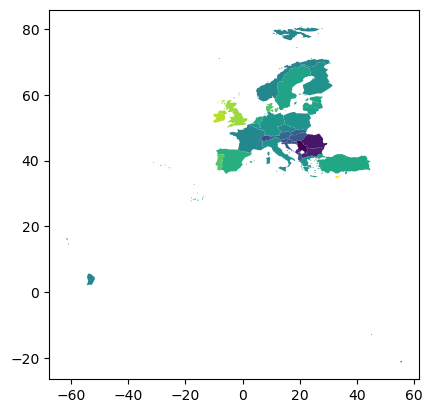

In [9]:
reduced_data_pd.plot("t2m")
print('# Note that the NUTS regions include French foreign territories, hence the extent of the figure.')

## Appendix

### Unadvised: return_as = 'pandas' for time-series

This results in very heavy memory usage but may be useful

In [10]:
reduced_data_pd = ek_aggregate.spatial.reduce(era5_data, nuts_data, return_as="pandas", mask_dim="FID")
reduced_data_pd[:5]

Returning reduced data in pandas format is considered experimental and may change in futureversions of earthkit


id NUTS_ID  LEVL_CODE CNTR_CODE NAME_LATN NUTS_NAME  \
FID time                                                                       
DK  2015-01-01 00:00:00  DK      DK          0        DK   Danmark   Danmark   
    2015-01-01 01:00:00  DK      DK          0        DK   Danmark   Danmark   
    2015-01-01 02:00:00  DK      DK          0        DK   Danmark   Danmark   
    2015-01-01 03:00:00  DK      DK          0        DK   Danmark   Danmark   
    2015-01-01 04:00:00  DK      DK          0        DK   Danmark   Danmark   

                         MOUNT_TYPE  URBN_TYPE  COAST_TYPE FID  \
FID time                                                         
DK  2015-01-01 00:00:00           0          0           0  DK   
    2015-01-01 01:00:00           0          0           0  DK   
    2015-01-01 02:00:00           0          0           0  DK   
    2015-01-01 03:00:00           0          0           0  DK   
    2015-01-01 04:00:00           0          0           0  DK   

                                                                  geometry  \
FID time                                                                     
DK  2015-01-01 00:00:00  MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...   
    2015-01-01 01:00:00  MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...   
    2015-01-01 02:00:00  MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...   
    2015-01-01 03:00:00  MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...   
    2015-01-01 04:00:00  MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...   

                         number   step  surface          valid_time  \
FID time                                                              
DK  2015-01-01 00:00:00       0 0 days      0.0 2015-01-01 00:00:00   
    2015-01-01 01:00:00       0 0 days      0.0 2015-01-01 01:00:00   
    2015-01-01 02:00:00       0 0 days      0.0 2015-01-01 02:00:00   
    2015-01-01 03:00:00       0 0 days      0.0 2015-01-01 03:00:00   
    2015-01-01 04:00:00       0 0 days      0.0 2015-01-01 04:00:00   

                                t2m  
FID time                             
DK  2015-01-01 00:00:00  278.709229  
    2015-01-01 01:00:00  278.938873  
    2015-01-01 02:00:00  279.068481  
    2015-01-01 03:00:00  279.241272  
    2015-01-01 04:00:00  279.418610

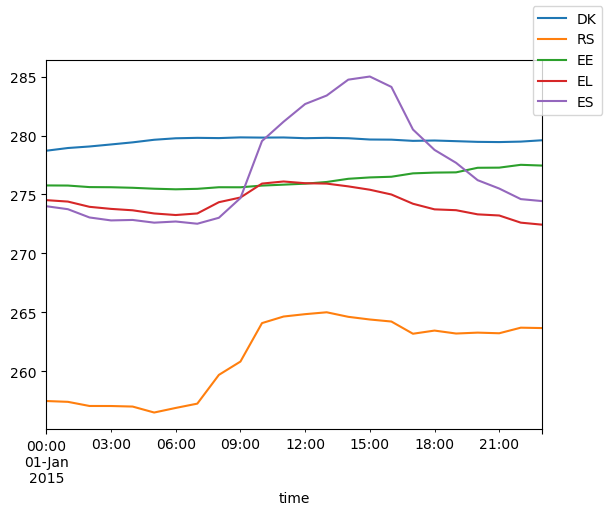

In [11]:
feature_index = "FID"
plot_var = "t2m"
# plot_x_vals = reduced_data.attrs[f"{plot_var}_dims"]["time"]
fig, ax = plt.subplots(1)
for feature in reduced_data_pd.index.get_level_values(feature_index).unique()[:5]:
    temp = reduced_data_pd.xs(feature, level=feature_index)
    temp[plot_var].plot(ax=ax, label=feature)
fig.legend()